# Object Detection Notes

Object Detection datasets

COCO (cocodataset.org)

In [3]:
# Import libs
import torch
import torchvision
%matplotlib inline
from d2l import torch as d2l

assert torch.cuda.is_available()

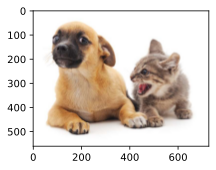

In [11]:
d2l.set_figsize()
img = d2l.plt.imread('../d2l-zh/pytorch/img/catdog.jpg')
d2l.plt.imshow(img)

In [6]:
def box_corner_to_center(boxes):
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes


def box_center_to_corner(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - 0.5 * w
    y1 = cy - 0.5 * h
    x2 = cx + 0.5 * w
    y2 = cy + 0.5 * h
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

In [7]:
dog_bbox, cat_bbox = [60.0, 45.0, 378.0, 516.0], [400.0, 112.0, 655.0, 493.0]

boxes = torch.tensor((dog_bbox, cat_bbox))
box_center_to_corner(box_corner_to_center(boxes)) == boxes

tensor([[True, True, True, True],
        [True, True, True, True]])

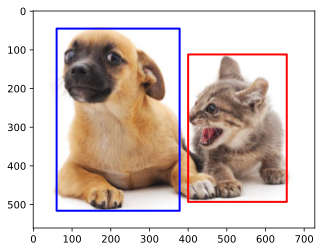

In [10]:
def bbox_to_rect(bbox, color):
    return d2l.plt.Rectangle(xy=(bbox[0], bbox[1]), width=bbox[2] - bbox[0], height=bbox[3] - bbox[1], fill=False, edgecolor=color, linewidth=2)


fig = d2l.plt.imshow(img)
fig.axes.add_patch(bbox_to_rect(dog_bbox, 'blue'))
fig.axes.add_patch(bbox_to_rect(cat_bbox, 'red'))

## 目标检测数据集：banana detection

In [14]:
import os
import pandas as pd
import torch
import torchvision
from d2l import torch as d2l

d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [16]:
def read_data_bananas(is_train=True):
    """读取香蕉检测数据集中的图像和标签"""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                             else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # 这里的target包含（类别，左上角x，左上角y，右下角x，右下角y），
        # 其中所有图像都具有相同的香蕉类（索引为0）
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [17]:
class BananaDataset(torch.utils.data.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print(f'read {len(self.features)} examples, is_train={is_train}')

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)

In [25]:
from torch.utils.data import DataLoader

def load_data_bananas(batch_size):
    train_iter = DataLoader(BananaDataset(is_train=True), batch_size, shuffle=True, num_workers=8)
    val_iter = DataLoader(BananaDataset(is_train=False), batch_size, shuffle=False, num_workers=8)
    return train_iter, val_iter

batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 examples, is_train=True
read 100 examples, is_train=False


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

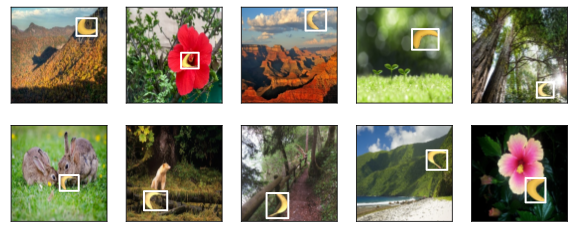

In [26]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])